In [1]:
import os, math, random, itertools, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image, ImageEnhance
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

plt.rcParams['figure.dpi'] = 140
SEED = 42
random.seed(SEED); np.random.seed(SEED)


2025-11-04 22:05:22.391642: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-04 22:05:22.447629: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-04 22:05:24.282426: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Found 41906 files belonging to 6 classes.
Found 8979 files belonging to 6 classes.
Found 8983 files belonging to 6 classes.
→ Loading ResNet50 with ImageNet weights…
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step
[WARN] Failed to load ImageNet weights: Size must be positive (size must be positive)
→ Fallback: weights=None

=== Stage 1: Feature extraction (frozen backbone) ===
Epoch 1/20
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.3906 - loss: 1.9130 - precision: 0.5409 - recall: 0.1160
[TF-CKPT] Saved BEST to: /home/student10/deep/dataset/deep_learning/leaf_preprocessed/results_resnet50/best_stage1_tf/ckpt-1  (val_accuracy=0.5596)
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 551s 416ms/step - accuracy: 0.4406 - loss: 1.4484 - precision: 0.6583 - recall: 0.1813 - val_accuracy: 0.5596 - val_loss: 1.1038 - val_precision: 0.7792 - val_recall: 0.3422
Epoch 2/20
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.4722 - loss: 1.2595 - precision: 0.7150 - recall: 0.2748
[TF-CKPT] 

2025-11-05 03:10:49.557285: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


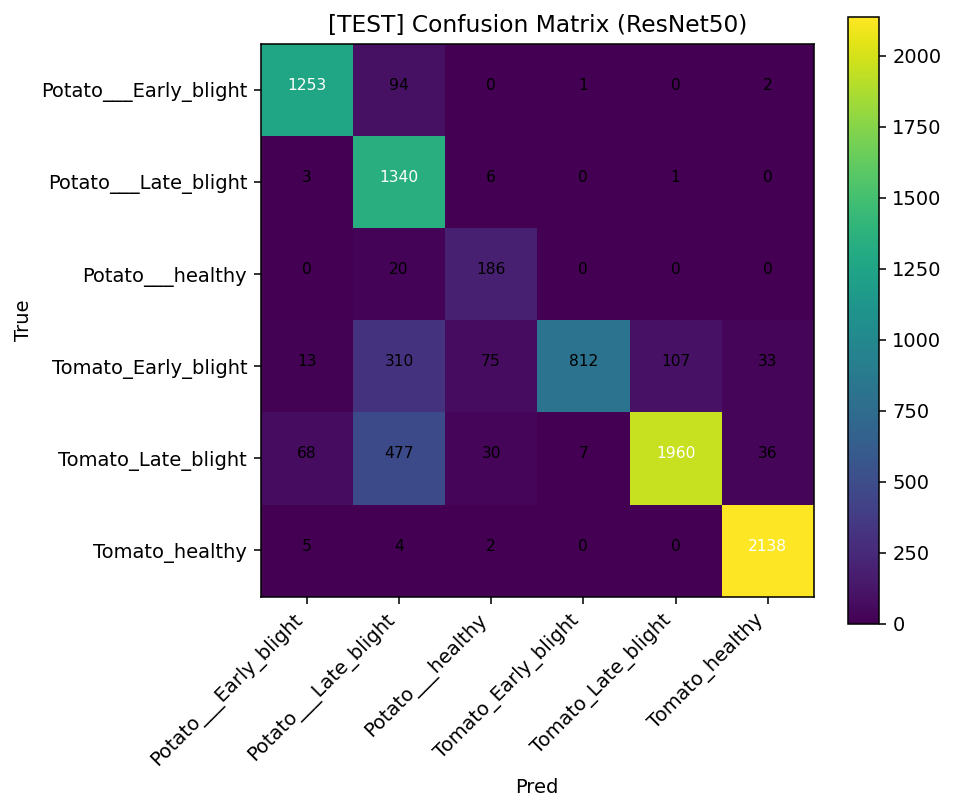

INFO:tensorflow:Assets written to: /home/student10/deep/dataset/deep_learning/leaf_preprocessed/results_resnet50/resnet50_savedmodel/assets


INFO:tensorflow:Assets written to: /home/student10/deep/dataset/deep_learning/leaf_preprocessed/results_resnet50/resnet50_savedmodel/assets


Saved artifact at '/home/student10/deep/dataset/deep_learning/leaf_preprocessed/results_resnet50/resnet50_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  140553483551136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140553483553248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140553483668640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140553483670224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140553483669168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140553483671632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140553483627232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140553483626176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140553483626000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1405518732

In [ ]:
import os, math, numpy as np, matplotlib.pyplot as plt, itertools, shutil, glob
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix

SPLIT_DIR = "/home/student10/Plant_Disease_Classification/leaf_preprocessed/splitted_dataset"
OUT_DIR   = "/home/student10/Plant_Disease_Classification/model_save"
os.makedirs(OUT_DIR, exist_ok=True)

IMG_TRAIN = str(Path(SPLIT_DIR)/"train")
IMG_VAL   = str(Path(SPLIT_DIR)/"val")
IMG_TEST  = str(Path(SPLIT_DIR)/"test")

SEED = 42
BATCH = 32
IMG_SIZE = (224, 224)
EPOCHS_FE = 20
EPOCHS_FT = 10
UNFREEZE_LAST = 40

try: tf.config.optimizer.set_jit(True)
except: pass

AUTOTUNE = tf.data.AUTOTUNE
preprocess = keras.applications.resnet.preprocess_input

def make_ds(root, shuffle=True):
    ds = tf.keras.utils.image_dataset_from_directory(
        root, labels="inferred", label_mode="categorical",
        image_size=IMG_SIZE, batch_size=BATCH, shuffle=shuffle, seed=SEED
    )
    ds = ds.map(lambda x,y: (preprocess(tf.cast(x, tf.float32)), y), num_parallel_calls=AUTOTUNE)
    return ds.cache().prefetch(AUTOTUNE)

train_ds = make_ds(IMG_TRAIN, True)
val_ds   = make_ds(IMG_VAL, False)
test_ds  = make_ds(IMG_TEST, False)

class_names = sorted([p.name for p in Path(IMG_TRAIN).iterdir() if p.is_dir()])
num_classes = len(class_names)
assert num_classes > 0, "Không tìm thấy class trong thư mục train."

def load_resnet50_safe(input_shape):
    try:
        print("→ Loading ResNet50 with ImageNet weights…")
        m = keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=input_shape)
        print("✓ Loaded ImageNet weights.")
        return m
    except Exception as e:
        print("[WARN] Failed to load ImageNet weights:", e)
        try:
            cache_dir = os.path.join(os.path.expanduser("~"), ".keras", "models")
            for f in glob.glob(os.path.join(cache_dir, "resnet50*")):
                try: os.remove(f)
                except: pass
        except: pass
        print("→ Fallback: weights=None")
        return keras.applications.ResNet50(include_top=False, weights=None, input_shape=input_shape)

base = load_resnet50_safe(IMG_SIZE + (3,))
base.trainable = False

inputs = keras.Input(shape=IMG_SIZE+(3,), name="input")
x = base(inputs, training=False)           
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax", dtype="float32")(x)
model = keras.Model(inputs, outputs, name="ResNet50_classifier")

model.compile(
    optimizer=keras.optimizers.SGD(1e-3, momentum=0.9, nesterov=True),
    loss="categorical_crossentropy",
    metrics=["accuracy", keras.metrics.Precision(name="precision"), keras.metrics.Recall(name="recall")]
)

class BestTFCheckpoint(keras.callbacks.Callback):
    def __init__(self, dirpath, monitor="val_accuracy", mode="max"):
        super().__init__()
        self.dirpath = dirpath
        self.monitor = monitor
        self.mode = mode
        self.best = -np.inf if mode=="max" else np.inf
        os.makedirs(self.dirpath, exist_ok=True)
        self.ckpt = None
        self.manager = None

    def set_model(self, model):
        self.ckpt = tf.train.Checkpoint(model=model)
        self.manager = tf.train.CheckpointManager(self.ckpt, self.dirpath, max_to_keep=1)

    def on_epoch_end(self, epoch, logs=None):
        if logs is None or self.monitor not in logs: return
        val = logs[self.monitor]
        improved = (val > self.best) if self.mode=="max" else (val < self.best)
        if improved:
            self.best = val
            path = self.manager.save(checkpoint_number=epoch+1)
            print(f"\n[TF-CKPT] Saved BEST to: {path}  ({self.monitor}={val:.4f})")

def restore_best(dirpath, model):
    ckpt = tf.train.Checkpoint(model=model)
    latest = tf.train.latest_checkpoint(dirpath)
    if latest:
        ckpt.restore(latest).expect_partial()
        print(f"✓ Restored best checkpoint from: {latest}")
        return True
    else:
        print(f"[INFO] No checkpoint found in: {dirpath}")
        return False

CKPT_DIR_FE = os.path.join(OUT_DIR, "best_stage1_tf")   
CKPT_DIR_FT = os.path.join(OUT_DIR, "best_finetune_tf") 

cb_stage1 = [
    BestTFCheckpoint(CKPT_DIR_FE, monitor="val_accuracy", mode="max"),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
]

print("\n=== Stage 1: Feature extraction (frozen backbone) ===")
history_fe = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_FE, callbacks=cb_stage1)

base.trainable = True
for layer in base.layers[:-UNFREEZE_LAST]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.SGD(5e-4, momentum=0.9, nesterov=True),
    loss="categorical_crossentropy",
    metrics=["accuracy", keras.metrics.Precision(name="precision"), keras.metrics.Recall(name="recall")]
)

cb_ft = [
    BestTFCheckpoint(CKPT_DIR_FT, monitor="val_accuracy", mode="max"),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
]

print("\n=== Stage 2: Fine-tuning last layers ===")
history_ft = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_FT, callbacks=cb_ft)

restored = restore_best(CKPT_DIR_FT, model) or restore_best(CKPT_DIR_FE, model)

probs = model.predict(test_ds, verbose=1)
y_pred = np.argmax(probs, axis=1)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in test_ds], axis=0)

print("\n[TEST] Classification Report (ResNet50):")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Confusion matrix
plt.figure(figsize=(7,6))
cm = confusion_matrix(y_true, y_pred)
plt.imshow(cm, interpolation='nearest'); plt.title("[TEST] Confusion Matrix (ResNet50)"); plt.colorbar()
ticks = np.arange(len(class_names))
plt.xticks(ticks, class_names, rotation=45, ha='right'); plt.yticks(ticks, class_names)
thr = cm.max()/2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i,j], ha="center", color="white" if cm[i,j] > thr else "black", fontsize=8)
plt.ylabel('True'); plt.xlabel('Pred'); plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "cm_resnet50_test.png"), dpi=140); plt.show()


savedmodel_dir = os.path.join(OUT_DIR, "resnet50_savedmodel")
if hasattr(model, "export"):  # Keras 3
    model.export(savedmodel_dir)
else:
    model.save(savedmodel_dir)
print("✓ SavedModel:", savedmodel_dir)

final_keras = os.path.join(OUT_DIR, "resnet50_final.keras")
try:
    model.save(final_keras)  
    print("✓ Keras file:", final_keras)
except Exception as e:
    print("[WARN] Skip saving .keras:", e)

def copy_ckpt_dir(src_dir, dst_dir):
    if not os.path.isdir(src_dir): return False
    os.makedirs(dst_dir, exist_ok=True)
    for f in os.listdir(src_dir):
        shutil.copy(os.path.join(src_dir, f), os.path.join(dst_dir, f))
    return True

best_ckpt_dir = os.path.join(OUT_DIR, "resnet50_best_tf_ckpt")
shutil.rmtree(best_ckpt_dir, ignore_errors=True)
if not copy_ckpt_dir(CKPT_DIR_FT, best_ckpt_dir):
    copy_ckpt_dir(CKPT_DIR_FE, best_ckpt_dir)
print("✓ Best TF checkpoint dir:", best_ckpt_dir)


Found 8983 files belonging to 6 classes.
✓ Using in-memory 'model'
→ Running prediction on test set ...
281/281 ━━━━━━━━━━━━━━━━━━━━ 94s 333ms/step


2025-11-05 07:13:25.421633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


✅ Prediction shape: (8983, 6)


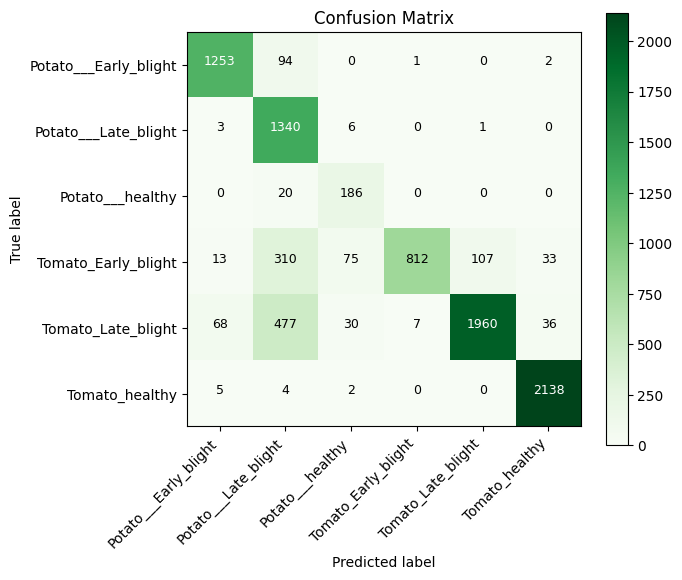

Saved: /home/student10/deep/result/results_resnet50/confusion_matrix.png
Saved: /home/student10/deep/result/results_resnet50/classification_report.txt


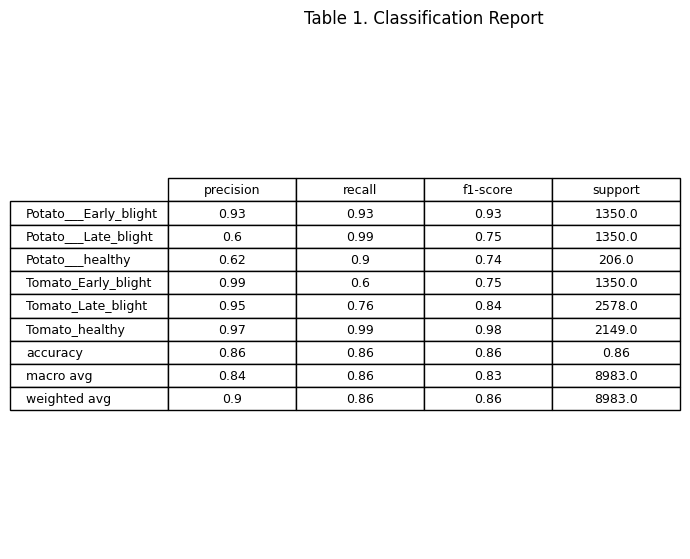

Saved: /home/student10/deep/result/results_resnet50/classification_report.png
⚠️ No history found to plot learning curves (skipped).

✅ All result figures are saved in: /home/student10/deep/result/results_resnet50


In [ ]:
import os, itertools, numpy as np, matplotlib.pyplot as plt, pandas as pd
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix

SPLIT_DIR  = "/home/student10/Plant_Disease_Classification/leaf_preprocessed/splitted_dataset"
MODEL_PATH = "/home/student10/Plant_Disease_Classification/model_save"
SAVE_DIR   = "/home/student10/Plant_Disease_Classification/model_save/results_resnet50"
Path(SAVE_DIR).mkdir(parents=True, exist_ok=True)

IMG_SIZE = (224,224)
BATCH    = 32

AUTOTUNE   = tf.data.AUTOTUNE
preprocess = keras.applications.resnet.preprocess_input

test_ds = tf.keras.utils.image_dataset_from_directory(
    Path(SPLIT_DIR)/"test",
    labels="inferred", label_mode="categorical",
    image_size=IMG_SIZE, batch_size=BATCH, shuffle=False
).map(lambda x,y: (preprocess(tf.cast(x, tf.float32)), y),
      num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

class_names = sorted([p.name for p in (Path(SPLIT_DIR)/"train").iterdir() if p.is_dir()])
num_classes = len(class_names)

def load_any_model(path):
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(path)
    if path.is_file() and path.suffix in {".keras", ".h5"}:
        print(f"→ Loading Keras model from {path}")
        return keras.models.load_model(path)
    elif path.is_dir():
        print(f"→ Loading SavedModel via TFSMLayer (Keras 3): {path}")
        layer = keras.layers.TFSMLayer(str(path), call_endpoint="serving_default")
        model = keras.Sequential([
            keras.layers.InputLayer(input_shape=IMG_SIZE+(3,)),
            layer
        ])
        return model
    else:
        raise ValueError(f"Unrecognized model format: {path}")

try:
    model  
    print("✓ Using in-memory 'model'")
except NameError:
    model = load_any_model(MODEL_PATH)

print("→ Running prediction on test set ...")
raw_preds = model.predict(test_ds, verbose=1)

if isinstance(raw_preds, dict):
    raw_preds = list(raw_preds.values())[0]
raw_preds = np.array(raw_preds)

if raw_preds.ndim == 1:  
    print("⚠️ Model output is 1D — converting to 2D one-hot (assumed class index).")
    raw_preds = tf.one_hot(raw_preds.astype(int), depth=num_classes).numpy()

probs = raw_preds
y_pred = np.argmax(probs, axis=1)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in test_ds], axis=0)

print("✅ Prediction shape:", probs.shape)

cm = confusion_matrix(y_true, y_pred)
fig = plt.figure(figsize=(7,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
plt.title("Confusion Matrix"); plt.colorbar()
ticks = np.arange(len(class_names))
plt.xticks(ticks, class_names, rotation=45, ha='right')
plt.yticks(ticks, class_names)
thr = cm.max()/2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i,j],
             ha="center",
             color="white" if cm[i,j] > thr else "black",
             fontsize=9)
plt.ylabel("True label"); plt.xlabel("Predicted label")
plt.tight_layout()
cm_path = os.path.join(SAVE_DIR, "confusion_matrix.png")
plt.savefig(cm_path, dpi=160); plt.show()
print("Saved:", cm_path)

rep_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True, digits=2)
rep_df   = pd.DataFrame(rep_dict).T
order    = class_names + ["accuracy","macro avg","weighted avg"]
rep_df   = rep_df.loc[order, ["precision","recall","f1-score","support"]]

txt_path = os.path.join(SAVE_DIR, "classification_report.txt")
with open(txt_path, "w") as f:
    f.write(classification_report(y_true, y_pred, target_names=class_names, digits=4))
print("Saved:", txt_path)

fig, ax = plt.subplots(figsize=(7, 3 + 0.3*len(order)))
ax.axis("off")
tbl = ax.table(cellText=np.round(rep_df.values, 2),
               rowLabels=rep_df.index,
               colLabels=rep_df.columns,
               cellLoc="center", loc="center")
tbl.auto_set_font_size(False); tbl.set_fontsize(9); tbl.scale(1,1.2)
ax.set_title("Table 1. Classification Report", pad=12)
cr_path = os.path.join(SAVE_DIR, "classification_report.png")
plt.tight_layout(); plt.savefig(cr_path, dpi=160); plt.show()
print("Saved:", cr_path)

def _merge_histories(hists, key):
    out = []
    for h in hists:
        if h is not None and hasattr(h, "history") and key in h.history:
            out += h.history[key]
    return out

hists = []
for name in ["history_fe", "history_ft", "history", "history_finetune"]:
    if name in globals():
        hists.append(globals()[name])

train_acc  = _merge_histories(hists, "accuracy")
val_acc    = _merge_histories(hists, "val_accuracy")
train_loss = _merge_histories(hists, "loss")
val_loss   = _merge_histories(hists, "val_loss")

if train_acc and val_acc:
    fig = plt.figure(figsize=(10,3.2))
    ax1 = plt.subplot(1,2,1)
    ax1.plot(train_acc, label="Train Acc"); ax1.plot(val_acc, label="Val Acc")
    ax1.set_title("Accuracy over epochs"); ax1.grid(True, alpha=0.3); ax1.legend()

    ax2 = plt.subplot(1,2,2)
    ax2.plot(train_loss, label="Train Loss"); ax2.plot(val_loss, label="Val Loss")
    ax2.set_title("Loss over epochs"); ax2.grid(True, alpha=0.3); ax2.legend()

    curves_path = os.path.join(SAVE_DIR, "learning_curves.png")
    plt.tight_layout(); plt.savefig(curves_path, dpi=160); plt.show()
    print("Saved:", curves_path)
else:
    print("⚠️ No history found to plot learning curves (skipped).")

print("\n✅ All result figures are saved in:", SAVE_DIR)


Parsed 26 epochs


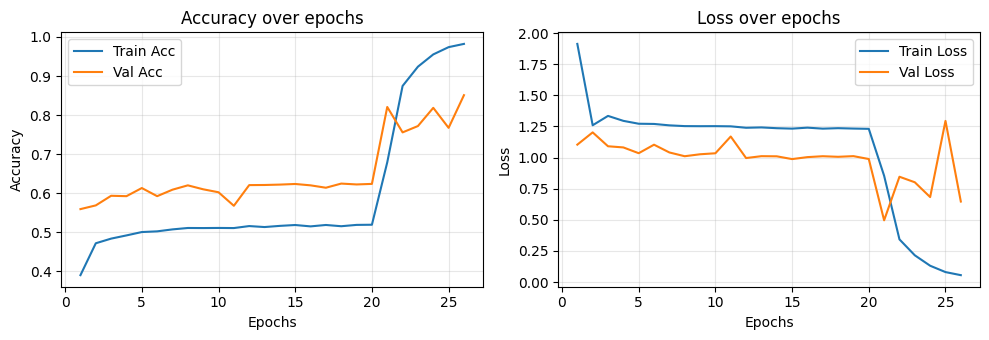

✅ Saved learning curve plot to: /home/student10/deep/result/results_resnet50/resnet50_learning_curves_from_log.png


In [ ]:
import re, matplotlib.pyplot as plt, numpy as np, os
from pathlib import Path

LOG_FILE = "/home/student10/deep/result/results_resnet50/train_log.txt"
SAVE_DIR = "/home/student10/deep/result/results_resnet50"
os.makedirs(SAVE_DIR, exist_ok=True)

pattern = re.compile(
    r"accuracy:\s*([\d\.]+).*?loss:\s*([\d\.]+).*?"
    r"val_accuracy:\s*([\d\.]+).*?val_loss:\s*([\d\.]+)",
    re.S
)

train_acc, train_loss, val_acc, val_loss = [], [], [], []

with open(LOG_FILE, "r", encoding="utf-8") as f:
    log = f.read()
    matches = pattern.findall(log)
    for acc, loss, vacc, vloss in matches:
        train_acc.append(float(acc))
        train_loss.append(float(loss))
        val_acc.append(float(vacc))
        val_loss.append(float(vloss))

epochs = np.arange(1, len(train_acc)+1)
print(f"Parsed {len(epochs)} epochs")

# --- Plot ---
plt.figure(figsize=(10,3.5))

plt.subplot(1,2,1)
plt.plot(epochs, train_acc, label="Train Acc")
plt.plot(epochs, val_acc, label="Val Acc")
plt.title("Accuracy over epochs")
plt.xlabel("Epochs"); plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3); plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Val Loss")
plt.title("Loss over epochs")
plt.xlabel("Epochs"); plt.ylabel("Loss")
plt.grid(True, alpha=0.3); plt.legend()

plt.tight_layout()
out_path = os.path.join(SAVE_DIR, "resnet50_learning_curves_from_log.png")
plt.savefig(out_path, dpi=160)
plt.show()

print(f"✅ Saved learning curve plot to: {out_path}")
